In [1]:
# imports iniciales
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import utils
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
## hay 38829 personas en total
events = pd.read_csv('events_up_to_01062018.csv',low_memory=False)
events['person'].drop_duplicates().to_frame().shape

(38829, 1)

In [4]:
## tomo todos los eventos
events = utils.get_events()
events.sort_values(by=['person', 'timestamp'], ascending=[True, True], inplace=True)
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,month,day,hora
1507286,2018-05-17 12:27:47,checkout,0008ed71,NaN,3372.0,Samsung Galaxy S6 Flat,Muito Bom,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,17,12
2336760,2018-05-17 13:44:59,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,Unknown,Unknown,Brazil,Computer,1920x1080,Windows 10,Chrome 66.0,5,17,13
1507716,2018-05-17 13:45:00,checkout,0008ed71,NaN,8247.0,iPhone SE,Bom,64GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,17,13
2336761,2018-05-17 16:21:54,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,Unknown,Unknown,Brazil,Computer,1920x1080,Windows 10,Chrome 66.0,5,17,16
2122051,2018-05-17 16:22:06,generic listing,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,"6594,6651,6664,7253,2820,6706,6721,12606,480,1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,17,16


In [5]:
## ctd de eventos de cada tipo por usuario (todos los usuarios están incluídos -> si o si tienen un evento)
features = utils.get_features_iniciales(events,'event')
print(features.shape)
features.head()

(38829, 12)


event,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
0,0008ed71,0,0,3,0,1,0,0,0,0,0,2
1,00091926,15,25,2,0,0,0,0,0,0,372,34
2,00091a7a,1,5,0,0,0,0,0,0,0,3,1
3,000ba417,1,24,6,1,14,0,1,0,0,153,6
4,000c79fe,1,0,1,0,1,0,1,9,0,3,1


In [6]:
# agrego columnas para segmentar el tiempo 
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')
events['month'] = events.timestamp.dt.month
events['day'] = events.timestamp.dt.day
events['hour'] = events.timestamp.dt.hour
events['weekday name'] = events.timestamp.dt.weekday_name
events[['person','timestamp','month','day','hour','weekday name']].head()

,person,timestamp,month,day,hour,weekday name
1507286,0008ed71,2018-05-17 12:27:47,5,17,12,Thursday
2336760,0008ed71,2018-05-17 13:44:59,5,17,13,Thursday
1507716,0008ed71,2018-05-17 13:45:00,5,17,13,Thursday
2336761,0008ed71,2018-05-17 16:21:54,5,17,16,Thursday
2122051,0008ed71,2018-05-17 16:22:06,5,17,16,Thursday


In [7]:
## 1 si es fin de semana 0 si es dia de semana
events['weekend'] = (events['weekday name'] == 'Saturday') | (events['weekday name'] == 'Sunday')
events['weekend'] = events['weekend'].astype(int)

In [8]:
## paso el mes a nombre
events['month'] = events['month'].apply(lambda x: calendar.month_abbr[x])

In [9]:
def periodioDia(hora):
    if (hora >= 0) & (hora < 7):
        return 'madrugada'
    elif (hora >= 7) & (hora < 12):
        return 'manana'
    elif (hora >= 12) & (hora < 15):
        return 'mediodia'
    elif (hora >= 15) & (hora < 20):
        return 'tarde'
    return 'noche'

events['periodo'] = events['hour'].apply(lambda x: periodioDia(x))

In [10]:
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,screen_resolution,operating_system_version,browser_version,month,day,hora,hour,weekday name,weekend,periodo
1507286,2018-05-17 12:27:47,checkout,0008ed71,NaN,3372.0,Samsung Galaxy S6 Flat,Muito Bom,32GB,Dourado,NaN,...,NaN,NaN,NaN,May,17,12,12,Thursday,0,mediodia
2336760,2018-05-17 13:44:59,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1920x1080,Windows 10,Chrome 66.0,May,17,13,13,Thursday,0,mediodia
1507716,2018-05-17 13:45:00,checkout,0008ed71,NaN,8247.0,iPhone SE,Bom,64GB,Cinza espacial,NaN,...,NaN,NaN,NaN,May,17,13,13,Thursday,0,mediodia
2336761,2018-05-17 16:21:54,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1920x1080,Windows 10,Chrome 66.0,May,17,16,16,Thursday,0,tarde
2122051,2018-05-17 16:22:06,generic listing,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,"6594,6651,6664,7253,2820,6706,6721,12606,480,1...",...,NaN,NaN,NaN,May,17,16,16,Thursday,0,tarde


In [11]:
#one hot encoding
events = pd.concat([events, pd.get_dummies(events['weekday name'], prefix='weekday')],axis=1)
events = events.drop('weekday name', axis=1)
events = pd.concat([events, pd.get_dummies(events['periodo'], prefix='periodo')],axis=1)
events = events.drop('periodo', axis=1)
events = pd.concat([events, pd.get_dummies(events['month'], prefix='mes')],axis=1)
events = events.drop('month', axis=1)

events = pd.concat([events, pd.get_dummies(events['storage'], prefix='storage')],axis=1)
events = events.drop('storage', axis=1)
events = pd.concat([events, pd.get_dummies(events['condition'], prefix='condition')],axis=1)
events = events.drop('condition', axis=1)

events.head()

,timestamp,event,person,url,sku,model,color,skus,search_term,staticpage,...,storage_32GB,storage_4GB,storage_512MB,storage_64GB,storage_8GB,condition_Bom,condition_Bom - Sem Touch ID,condition_Excelente,condition_Muito Bom,condition_Novo
1507286,2018-05-17 12:27:47,checkout,0008ed71,NaN,3372.0,Samsung Galaxy S6 Flat,Dourado,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,1,0
2336760,2018-05-17 13:44:59,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1507716,2018-05-17 13:45:00,checkout,0008ed71,NaN,8247.0,iPhone SE,Cinza espacial,NaN,NaN,NaN,...,0,0,0,1,0,1,0,0,0,0
2336761,2018-05-17 16:21:54,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2122051,2018-05-17 16:22:06,generic listing,0008ed71,NaN,0.0,NaN,NaN,"6594,6651,6664,7253,2820,6706,6721,12606,480,1...",NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [12]:
events.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'color', 'skus',
       'search_term', 'staticpage', 'campaign_source', 'search_engine',
       'channel', 'new_vs_returning', 'city', 'region', 'country',
       'device_type', 'screen_resolution', 'operating_system_version',
       'browser_version', 'day', 'hora', 'hour', 'weekend', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'periodo_madrugada', 'periodo_manana', 'periodo_mediodia',
       'periodo_noche', 'periodo_tarde', 'mes_Apr', 'mes_Feb', 'mes_Jan',
       'mes_Mar', 'mes_May', 'storage_128GB', 'storage_16GB', 'storage_256GB',
       'storage_32GB', 'storage_4GB', 'storage_512MB', 'storage_64GB',
       'storage_8GB', 'condition_Bom', 'condition_Bom - Sem Touch ID',
       'condition_Excelente', 'condition_Muito Bom', 'condition_Novo'],
      dtype='object')

In [13]:
events = events[['person', 'day', 'hora', 'hour', 'weekend', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'periodo_madrugada', 'periodo_manana', 'periodo_mediodia',
       'periodo_noche', 'periodo_tarde', 'mes_Apr', 'mes_Feb', 'mes_Jan',
       'mes_Mar', 'mes_May', 'storage_128GB', 'storage_16GB', 'storage_256GB',
       'storage_32GB', 'storage_4GB', 'storage_512MB', 'storage_64GB',
       'storage_8GB', 'condition_Bom', 'condition_Bom - Sem Touch ID',
       'condition_Excelente', 'condition_Muito Bom', 'condition_Novo']]
events.dtypes

person                          object
day                              int64
hora                             int64
hour                             int64
weekend                          int64
weekday_Friday                   uint8
weekday_Monday                   uint8
weekday_Saturday                 uint8
weekday_Sunday                   uint8
weekday_Thursday                 uint8
weekday_Tuesday                  uint8
weekday_Wednesday                uint8
periodo_madrugada                uint8
periodo_manana                   uint8
periodo_mediodia                 uint8
periodo_noche                    uint8
periodo_tarde                    uint8
mes_Apr                          uint8
mes_Feb                          uint8
mes_Jan                          uint8
mes_Mar                          uint8
mes_May                          uint8
storage_128GB                    uint8
storage_16GB                     uint8
storage_256GB                    uint8
storage_32GB             

In [14]:
features = pd.merge(features, events.groupby('person').mean().reset_index(), on='person', how='inner')

In [15]:
features.head()

,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,storage_32GB,storage_4GB,storage_512MB,storage_64GB,storage_8GB,condition_Bom,condition_Bom - Sem Touch ID,condition_Excelente,condition_Muito Bom,condition_Novo
0,0008ed71,0,0,3,0,1,0,0,0,0,...,0.333333,0.000000,0.0,0.166667,0.000000,0.333333,0.0,0.000000,0.166667,0.000000
1,00091926,15,25,2,0,0,0,0,0,0,...,0.294643,0.000000,0.0,0.178571,0.000000,0.227679,0.0,0.241071,0.363839,0.002232
2,00091a7a,1,5,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.100000,0.000000,0.100000,0.0,0.200000,0.000000,0.000000
3,000ba417,1,24,6,1,14,0,1,0,0,...,0.097087,0.004854,0.0,0.004854,0.106796,0.558252,0.0,0.053398,0.165049,0.000000
4,000c79fe,1,0,1,0,1,0,1,9,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.235294,0.0,0.000000,0.000000,0.000000


In [16]:
events = pd.read_csv('events_up_to_01062018.csv',low_memory=False)
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')

# Tomo como sesión media hora
events = events.sort_values(by='timestamp')
events['timestamp_anterior'] = events.groupby('person')['timestamp'].shift()
events['start_session'] = ((events['timestamp'] - events['timestamp_anterior']) >= timedelta(minutes=30)) | events['timestamp_anterior'].isnull()
events['start_session'] = events['start_session'].astype(int)
events['session_num'] = events.groupby('person')['start_session'].cumsum()
events['session_id'] =  events['person'] + '-' + events['session_num'].astype(str)

In [17]:
session_df = events.groupby(['session_id','person']).agg({'event':'count', 'timestamp':['min','max']})
session_df.columns = session_df.columns.droplevel()
session_df.columns = ['number_events','timestamp_min','timestamp_max']
session_df['total_time'] = ((session_df['timestamp_max']) - session_df['timestamp_min']).astype('timedelta64[s]')
session_df = session_df.reset_index().sort_values(by='session_id')
session_df.head()

,session_id,person,number_events,timestamp_min,timestamp_max,total_time
0,0008ed71-1,0008ed71,1,2018-05-17 12:27:47,2018-05-17 12:27:47,0.0
1,0008ed71-2,0008ed71,2,2018-05-17 13:44:59,2018-05-17 13:45:00,1.0
2,0008ed71-3,0008ed71,3,2018-05-17 16:21:54,2018-05-17 16:28:37,403.0
3,00091926-1,00091926,7,2018-05-03 22:08:29,2018-05-03 22:09:59,90.0
4,00091926-10,00091926,4,2018-05-11 02:23:38,2018-05-11 02:23:57,19.0


In [18]:
sessions_by_person = session_df.groupby(['person']).agg({'session_id':'count', 'total_time':['sum','mean','max'], 'number_events':['mean', 'max'], 'timestamp_max':'max'})
sessions_by_person.columns = sessions_by_person.columns.droplevel()
sessions_by_person.columns = ['sessions', 'total_time', 'mean_time_by_session', 'max_session_time', 'mean_events_by_session', 'max_events_by_session', 'days_since_last_session']
sessions_by_person = sessions_by_person.reset_index()
sessions_by_person['days_since_last_session'] = pd.datetime.today() - sessions_by_person['days_since_last_session']
sessions_by_person['days_since_last_session'] = sessions_by_person['days_since_last_session'].dt.days
sessions_by_person.head()

,person,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session
0,0008ed71,3,404.0,134.666667,403.0,2.000000,3,193
1,00091926,34,14890.0,437.941176,2129.0,13.176471,63,179
2,00091a7a,1,347.0,347.000000,347.0,10.000000,10,245
3,000ba417,5,12703.0,2540.600000,5450.0,41.200000,79,184
4,000c79fe,1,620.0,620.000000,620.0,17.000000,17,182


In [19]:
sessions_by_person.shape

(38829, 8)

In [20]:
features = pd.merge(features, sessions_by_person, on='person', how='inner')
features.head()

,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,condition_Excelente,condition_Muito Bom,condition_Novo,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session
0,0008ed71,0,0,3,0,1,0,0,0,0,...,0.000000,0.166667,0.000000,3,404.0,134.666667,403.0,2.000000,3,193
1,00091926,15,25,2,0,0,0,0,0,0,...,0.241071,0.363839,0.002232,34,14890.0,437.941176,2129.0,13.176471,63,179
2,00091a7a,1,5,0,0,0,0,0,0,0,...,0.200000,0.000000,0.000000,1,347.0,347.000000,347.0,10.000000,10,245
3,000ba417,1,24,6,1,14,0,1,0,0,...,0.053398,0.165049,0.000000,5,12703.0,2540.600000,5450.0,41.200000,79,184
4,000c79fe,1,0,1,0,1,0,1,9,0,...,0.000000,0.000000,0.000000,1,620.0,620.000000,620.0,17.000000,17,182


In [21]:
# Se guardan los features finales en un csv en la carpeta modelos, para que lo levante el modlo a entrenar
features.to_csv('../modelos/data_set.csv',index=False)

In [22]:
# no perdí ningun usuario
features.shape

(38829, 53)

In [23]:
#################################################################

In [24]:
########## https://jessesw.com/XG-Boost/

In [25]:
training_labels = pd.read_csv("labels_training_set.csv", low_memory=False)
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
features = pd.read_csv('../modelos/data_set.csv', low_memory = False)

In [26]:
training_labels.shape

(19414, 2)

In [27]:
labels_predict.shape

(19415, 1)

In [28]:
training_labels = pd.merge(features, training_labels, on='person', how='inner')
print(training_labels.shape)
training_labels.head(2)

(19414, 54)


,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,condition_Muito Bom,condition_Novo,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session,label
0,0008ed71,0,0,3,0,1,0,0,0,0,...,0.166667,0.0,3,404.0,134.666667,403.0,2.0,3,193,0
1,000c79fe,1,0,1,0,1,0,1,9,0,...,0.000000,0.0,1,620.0,620.000000,620.0,17.0,17,182,0


In [29]:
labels_predict = pd.merge(features, labels_predict, on='person', how='inner')
print(labels_predict.shape)
labels_predict.head(2)

(19415, 53)


,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,condition_Excelente,condition_Muito Bom,condition_Novo,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session
0,00091926,15,25,2,0,0,0,0,0,0,...,0.241071,0.363839,0.002232,34,14890.0,437.941176,2129.0,13.176471,63,179
1,00091a7a,1,5,0,0,0,0,0,0,0,...,0.200000,0.000000,0.000000,1,347.0,347.000000,347.0,10.000000,10,245


In [30]:
train = training_labels
target = 'label'
IDcol = 'person'

In [31]:
predictors = [x for x in train.columns if x not in [target, IDcol]]

In [32]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [33]:
optimized_GBM.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [34]:
optimized_GBM.grid_scores_

[mean: 0.94622, std: 0.00076, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.94602, std: 0.00161, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.94684, std: 0.00184, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.94674, std: 0.00108, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.94592, std: 0.00097, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.94602, std: 0.00104, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.94762, std: 0.00093, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.94653, std: 0.00102, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.94597, std: 0.00133, params: {'max_depth': 7, 'min_child_weight': 5}]

In [35]:
####### mejor [mean: 0.94622, std: 0.00076, params: {'max_depth': 3, 'min_child_weight': 1},


In [36]:
xgdmat = xgb.DMatrix(train[predictors],train[target])

In [37]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 
              'max_depth':3, 'min_child_weight':1} 

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'],
                early_stopping_rounds = 100)

[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:19] /work

[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:20] /work

[12:20:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:22] /work

[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:23] /work

[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:24] /work

[12:20:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:20:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:26] /work

[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:27] /work

[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:20:28] /worksp

[12:20:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:30] /works

[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:31] /work

[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:20:32] /work

In [40]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
50,0.049037,0.000420,0.050118,0.002399
51,0.048960,0.000572,0.050170,0.002393
52,0.048869,0.000541,0.050118,0.002366
53,0.048805,0.000550,0.050118,0.002366
54,0.048766,0.000571,0.050067,0.002438


In [41]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 
              'max_depth':3, 'min_child_weight':1} 
## round 54 ( de arriba )
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 54)

[12:21:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:21:53] /work

In [42]:
##########

In [43]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

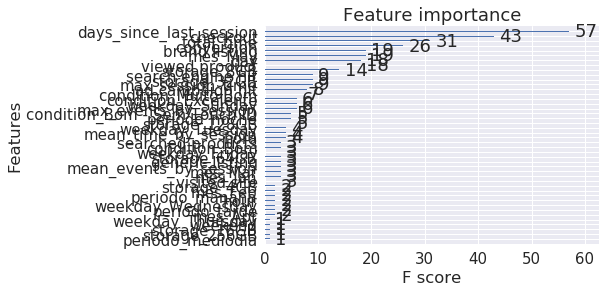

In [44]:
xgb.plot_importance(final_gb) # fixear

In [45]:
importances = final_gb.get_fscore()
importances

{'checkout': 43,
 'max_session_time': 9,
 'max_events_by_session': 6,
 'hora': 4,
 'days_since_last_session': 57,
 'viewed product': 18,
 'total_time': 31,
 'mean_time_by_session': 4,
 'storage_128GB': 5,
 'mes_May': 19,
 'conversion': 26,
 'periodo_noche': 5,
 'storage_32GB': 9,
 'visited site': 3,
 'mes_Apr': 2,
 'day': 18,
 'periodo_tarde': 2,
 'brand listing': 19,
 'mes_Jan': 3,
 'ad campaign hit': 8,
 'storage_8GB': 14,
 'weekday_Tuesday': 4,
 'weekday_Sunday': 6,
 'mes_Mar': 3,
 'mean_events_by_session': 3,
 'condition_Excelente': 6,
 'weekday_Wednesday': 2,
 'hour': 2,
 'condition_Bom - Sem Touch ID': 5,
 'periodo_manana': 2,
 'generic listing': 3,
 'storage_64GB': 3,
 'condition_Muito Bom': 7,
 'search engine hit': 9,
 'weekday_Friday': 3,
 'periodo_mediodia': 1,
 'mes_Feb': 2,
 'condition_Bom': 3,
 'searched products': 3,
 'storage_256GB': 1,
 'storage_4GB': 2,
 'storage_16GB': 1,
 'weekend': 1,
 'weekday_Thursday': 1}

In [ ]:
################### FALTA SEPARAR EN TEST Y TRAIN PARA HACER ESTO

In [ ]:
#testdmat = xgb.DMatrix(x_test)

In [ ]:
#from sklearn.metrics import accuracy_score
#y_pred = final_gb.predict(testdmat) # Predict using our testdmat
#y_pred

In [ ]:
#y_pred[y_pred > 0.5] = 1
#y_pred[y_pred <= 0.5] = 0
#y_pred

In [ ]:
#accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)


In [ ]:
################ pred finales p kaggle

In [46]:
set_test = labels_predict
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])
set_test = set_test.fillna(0)

final_test = set_test
testdmat = xgb.DMatrix(final_test)

In [47]:
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([0.05116463, 0.11915647, 0.05673879, ..., 0.11309602, 0.07226063,
       0.01204747], dtype=float32)

In [48]:
predicts_kaggel = y_pred.tolist()
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.head()

,0
0,0.051165
1,0.119156
2,0.056739
3,0.049634
4,0.019801


In [49]:
df_kaggel["person"] = personas
df_kaggel.rename(columns = {0: 'label'},inplace = True) 

In [50]:
df_kaggel = df_kaggel[['person','label']]

In [51]:
df_kaggel.shape

(19415, 2)

In [52]:
df_kaggel.to_csv('Resultados_new_xgb.csv',index=False)